In [12]:
import pandas as pd
from utils import *
import xgboost as xgb

In [27]:
raw = numerize_csv('train.csv', expand_classes=True)
# combined=combine_related_columns(raw)

# Data
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

Y = raw['Discontinued'].to_numpy()
X = raw.drop('Discontinued', axis=1).to_numpy()

kf = KFold(n_splits=5)

#X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=5, train_size = .75)

In [28]:
def get_cross_validation_accuracies(clf, kf, X, Y):
    fold_accs = np.zeros((kf.get_n_splits(X), 6))
    for j, (train_index, test_index) in enumerate(kf.split(X)):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = Y[train_index]
        y_test = Y[test_index]

        clf.fit(X_train, y_train)
        y_test_preds = clf.predict(X_test)
        y_train_preds = clf.predict(X_train)
        y_test_prob_preds = clf.predict_proba(X_test)
        y_train_prob_preds = clf.predict_proba(X_train)

        fold_accs[j,0] = roc_auc_score(y_test, y_test_preds)
        fold_accs[j,1] = roc_auc_score(y_train, y_train_preds)
        fold_accs[j,2] = roc_auc_score(y_test, y_test_prob_preds[:, 1])
        fold_accs[j,3] = roc_auc_score(y_train, y_train_prob_preds[:, 1])
        fold_accs[j,4] = accuracy_score(y_test, y_test_preds)
        fold_accs[j,5] = accuracy_score(y_train, y_train_preds)

    return np.average(fold_accs, axis=0)

def plot_accuracies(x_vals, accuracies, condensed, title, xlabel, ylabel):
    if not condensed:
        plt.plot(x_vals, accuracies[:,0], label="ROC AUC Testing")
        plt.plot(x_vals, accuracies[:,1], label="ROC AUC Training")
        plt.plot(x_vals, accuracies[:,2], label="ROC AUC Testing with Probabilities")
        plt.plot(x_vals, accuracies[:,3], label="ROC AUC Training with Probabilities")
        plt.plot(x_vals, accuracies[:,4], label="Testing")
        plt.plot(x_vals, accuracies[:,5], label="Training")
    else:
        plt.plot(x_vals, accuracies[:,0], label="Testing")
        plt.plot(x_vals, accuracies[:,1], label="Training")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

Depth: 1
ROC AUC Testing Accuracy: 0.7109867704588597
ROC AUC Training Accuracy: 0.7215345345973464
ROC AUC Testing Accuracy with Probabilities: 0.848734680587231
ROC AUC Training Accuracy with Probabilities: 0.8566222547442381
Testing Accuracy: 0.804415201297723
Training Accuracy: 0.8123712697748114
Depth: 2
ROC AUC Testing Accuracy: 0.7122920754030497
ROC AUC Training Accuracy: 0.7384077812963004
ROC AUC Testing Accuracy with Probabilities: 0.84395400998036
ROC AUC Training Accuracy with Probabilities: 0.8781601162394752
Testing Accuracy: 0.801795580594416
Training Accuracy: 0.8220101743987172
Depth: 3
ROC AUC Testing Accuracy: 0.7083493860870892
ROC AUC Training Accuracy: 0.7744577043248997
ROC AUC Testing Accuracy with Probabilities: 0.8352864426942725
ROC AUC Training Accuracy with Probabilities: 0.9100498098797303
Testing Accuracy: 0.7984254947919404
Training Accuracy: 0.8461540061352884
Depth: 4
ROC AUC Testing Accuracy: 0.7035589124025576
ROC AUC Training Accuracy: 0.8224865490

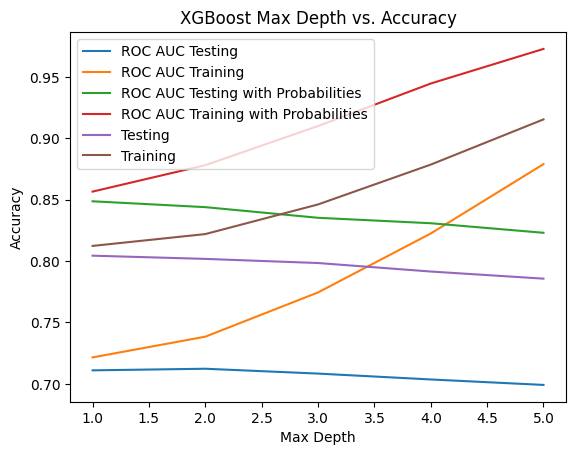

In [31]:
# Test with different max_depths
max_depths = [1, 2, 3, 4, 5]
accuracies = np.zeros((len(max_depths), 6))
for (i, depth) in enumerate(max_depths):
    print("Depth: " + str(depth))
    clf = xgb.XGBClassifier(max_depth=depth, random_state=0)
    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

    print(f'ROC AUC Testing Accuracy: {accuracies[i,0]}')
    print(f'ROC AUC Training Accuracy: {accuracies[i,1]}')
    print(f'ROC AUC Testing Accuracy with Probabilities: {accuracies[i,2]}')
    print(f'ROC AUC Training Accuracy with Probabilities: {accuracies[i,3]}')
    print(f'Testing Accuracy: {accuracies[i,4]}')
    print(f'Training Accuracy: {accuracies[i,5]}')

plot_accuracies(max_depths, accuracies, False, "XGBoost Max Depth vs. Accuracy", "Max Depth", "Accuracy")

Number of Estimators: 10
ROC AUC Testing Accuracy: 0.6066940538581207
ROC AUC Training Accuracy: 0.6102740206268052
ROC AUC Testing Accuracy with Probabilities: 0.8334370273576999
ROC AUC Training Accuracy with Probabilities: 0.8353201614125109
Testing Accuracy: 0.7763428315167312
Training Accuracy: 0.7784475805017145
Number of Estimators: 50
ROC AUC Testing Accuracy: 0.701106939576714
ROC AUC Training Accuracy: 0.7102876821563294
ROC AUC Testing Accuracy with Probabilities: 0.8473448852845211
ROC AUC Training Accuracy with Probabilities: 0.8529728391347928
Testing Accuracy: 0.8025434180146659
Training Accuracy: 0.8100784780544406
Number of Estimators: 100
ROC AUC Testing Accuracy: 0.7109867704588597
ROC AUC Training Accuracy: 0.7215345345973464
ROC AUC Testing Accuracy with Probabilities: 0.848734680587231
ROC AUC Training Accuracy with Probabilities: 0.8566222547442381
Testing Accuracy: 0.804415201297723
Training Accuracy: 0.8123712697748114
Number of Estimators: 200
ROC AUC Testing 

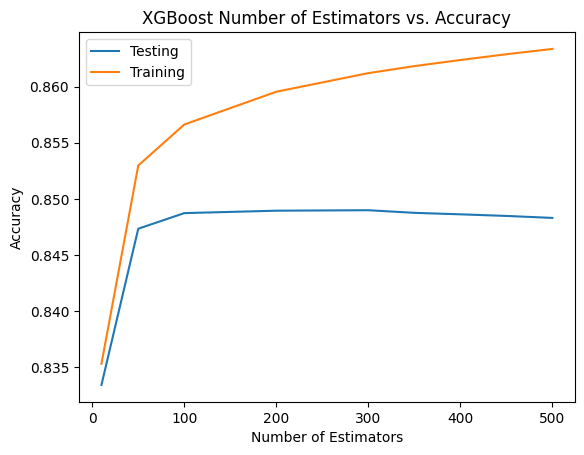

In [34]:
# Test with different n_estimators
num_estimators = [10, 50, 100, 200, 300, 350, 400, 450, 500]
accuracies = np.zeros((len(num_estimators), 6))
for (i, num) in enumerate(num_estimators):
    print("Number of Estimators: " + str(num))
    clf = xgb.XGBClassifier(max_depth=1, n_estimators=num, random_state=0)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

    print(f'ROC AUC Testing Accuracy: {accuracies[i,0]}')
    print(f'ROC AUC Training Accuracy: {accuracies[i,1]}')
    print(f'ROC AUC Testing Accuracy with Probabilities: {accuracies[i,2]}')
    print(f'ROC AUC Training Accuracy with Probabilities: {accuracies[i,3]}')
    print(f'Testing Accuracy: {accuracies[i,4]}')
    print(f'Training Accuracy: {accuracies[i,5]}')

plot_accuracies(num_estimators, accuracies[:,[2,3]], True, "XGBoost Number of Estimators vs. Accuracy", "Number of Estimators", "Accuracy")

Learning Rate: 1
ROC AUC Testing Accuracy: 0.7142848179930683
ROC AUC Training Accuracy: 0.7320309678617962
ROC AUC Testing Accuracy with Probabilities: 0.8461078586858152
ROC AUC Training Accuracy with Probabilities: 0.8686282605357617
Testing Accuracy: 0.8038556808666435
Training Accuracy: 0.8176117473530965
Learning Rate: 0.5
ROC AUC Testing Accuracy: 0.7142968065964905
ROC AUC Training Accuracy: 0.7267873043004297
ROC AUC Testing Accuracy with Probabilities: 0.8480188949369021
ROC AUC Training Accuracy with Probabilities: 0.8636137428501973
Testing Accuracy: 0.8059131534599524
Training Accuracy: 0.8149446756807789
Learning Rate: 0.1
ROC AUC Testing Accuracy: 0.7135841622561718
ROC AUC Training Accuracy: 0.7213021376622676
ROC AUC Testing Accuracy with Probabilities: 0.8489009916467325
ROC AUC Training Accuracy with Probabilities: 0.8562561830247439
Testing Accuracy: 0.8068479064406162
Training Accuracy: 0.812277680631152
Learning Rate: 0.05
ROC AUC Testing Accuracy: 0.7005778734255

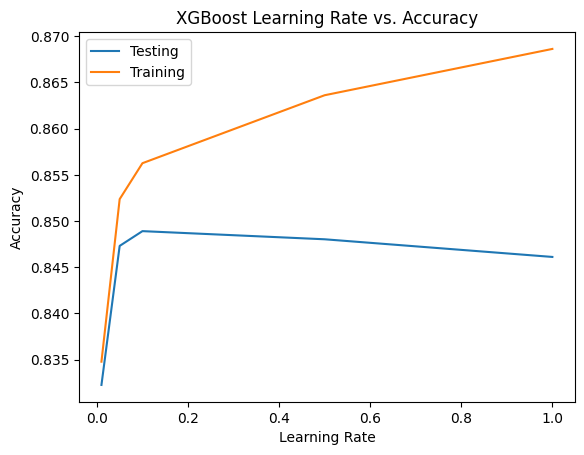

In [37]:
# Test with different learning_rates
lrs = [1, 0.5, 0.1, 0.05, 0.01]
accuracies = np.zeros((len(lrs), 6))
for (i, lr) in enumerate(lrs):
    print("Learning Rate: " + str(lr))
    clf = xgb.XGBClassifier(max_depth=1, n_estimators=300, learning_rate = lr, random_state=0)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

    print(f'ROC AUC Testing Accuracy: {accuracies[i,0]}')
    print(f'ROC AUC Training Accuracy: {accuracies[i,1]}')
    print(f'ROC AUC Testing Accuracy with Probabilities: {accuracies[i,2]}')
    print(f'ROC AUC Training Accuracy with Probabilities: {accuracies[i,3]}')
    print(f'Testing Accuracy: {accuracies[i,4]}')
    print(f'Training Accuracy: {accuracies[i,5]}')

plot_accuracies(lrs, accuracies[:,[2,3]], True, "XGBoost Learning Rate vs. Accuracy", "Learning Rate", "Accuracy")

In [38]:
# Generate submission using test.csv

raw_test = numerize_csv_test('test.csv', expand_classes=True)

clf = xgb.XGBClassifier(max_depth=1, n_estimators=300, learning_rate = 0.1, random_state=0)
clf.fit(X, Y)
y_test_prob_preds = clf.predict_proba(raw_test)
write_submission(y_test_prob_preds[:, 1])

In [92]:
df = pd.read_csv("submission (7).csv")

In [94]:
new = 0.2 * np.array(y_test_prob_preds[:, 1]) + 0.8 * np.array(df['TARGET'])
write_submission(new)